<a href="https://colab.research.google.com/github/alberto1971/Curso-de-introduccion-a-Big-Data-Parte-3-nov2021/blob/main/Arboles_decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style='color: blue;'>ARBOLES DE DECISION, BOSQUES ALEATORIOS Y BOOSTED</h1>

Veremos en este apartado un ejemplo de algoritmo de entrenamiento supervisado de clasificación. Se trata de los *_árboles de decision_* y veremos que es un sencillo y potente algoritmo que aprende diferentes clases de los datos y puede ser luego utilizado para predecir las clases de nuevas muestras de entrada.

En Machine Learning veremos también árboles de regresión. A pesar de que se llaman *Regression* estos modelos pueden utilizarse para clasificar también. El termino regresión se refiere a que el espacio de las variables es continuo, en lugar de ser clases discretas.

En machine learning se utilizan __conjuntos de estimadores simples__ (*ensembles*) para crear metodos más potentes. Hay muchos modelos de algoritmos a esta categoría (*ensemble learners*) pero hay dos conjuntos en particular que se han demostrado muy potentes, son los conjuntos de arboles de decision: *_Random Forests_* y *_Gradient Boosted Decision Trees_*.

Veremos como los *Random Forests* y *Gradient Boosted Decision Trees* consiguen que la suma de un numero de estimadores obtenga mejores resultados que los estimadores individuales.

Empezamos importando las librerías numéricas: 

In [ ]:
#IMPORTA: matplotlib inline, matplotlib.pyplot as plt, numpy as np:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. ARBOLES DE DECISION

En esencia un arbol de decision es un jerarquía de preguntas 'si-no' que lleva a una decision. 

Los arboles de decisión son una manera muy intuitiva de clasificar objetos. Simplemente se va haciendo una serie de preguntas hasta discriminar todas las posibles clases de objetos.

Por ejemplo para discriminar diferentes clases de animales podríamos construir un arbol de decisión como el siguiente en el que los nodos representan las preguntas y los nodos terminales son las hojas del arbol, donde se encuentran los objetos de una clase:


![](figuras/decision-tree.png)

## 1.1 Generamos datos
Utilizamos el generador <b>make_blobs</b> para crear conjuntos de datos n-dimensionales que se agrupan en clusters entorno a un centro dado y distribuidos en forma normal con una desviación estandard data.

make_blobs permite controlar la posicion del centro y de la desviacion estandar y es util para demostrar nuestra clasificación.

<a href='http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs'>Ver parametros de make_blobs</a>

Consideramos datos bi-dimensionales y generamos 4 clases:

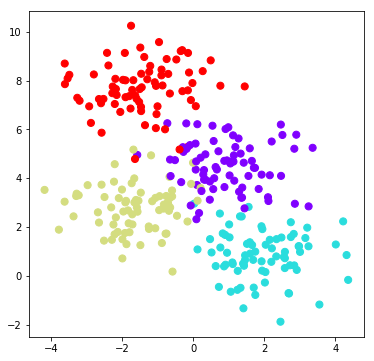

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

## 1.2 Generamos el modelo

El algoritmo clasifica todos los datos de entrenamiento con el menor número posible de preguntas. Para conseguirlo, el algoritmo busca sobre todas las posibles preguntas y selecciona la que es la más informativa sobre la variable objetivo de la clasificación, la que mejor separa las clases.

Para decidir el cual es el corte de decisión más informativo, hemos de utilizar una medida de cantidad de información que tienen los datos. 

Para esta medida utilizaremos el concepto de entropía o desorden/impureza en los datos. Intuitivamente cuanta más entropía tienen unos datos, más desordenado está y más info tiene.

<a href='http://www.bogotobogo.com/python/scikit-learn/scikt_machine_learning_Decision_Tree_Learning_Informatioin_Gain_IG_Impurity_Entropy_Gini_Classification_Error.php'>Sobre las medidas de info utilizadas en los arboles de decision</a>

Para entender el desorden que hay en un set de datos vamos a calcular diferentes medidas de entropía: la entropía de un conjunto de datos inicial y la de dos subconjuntos del mismo dividos por una decisión de clasificación. También calcularemos la ganancia de info que se obtiene al dividir el conjunto de datos inicial.

In [ ]:
# Definición de una función para el calculo de la Entropía

from math import log

def calcShannonEnt(counts):
    # Calcula la entropía de un conjunto de datos con n clases si se pasan los conteos de muestras para cada clase
    # counts es una lista de conteos de elementos de cada clase
    # por ejemplo para 300 muestras divididas en 4 clases equiprobables -> counts= [75,75,75,75]
    numEntries = sum(counts)
    shannonEnt = 0
    for e in counts:
        prob = float(e)/numEntries
        # cuando x=0 el lim xlog(x) = 0 por la regla de l'Hopital
        if prob == 0: 
            entropy_e = 0
        else:            
            entropy_e = prob * log(prob,2)
            
        shannonEnt -= entropy_e
    return shannonEnt

# Medidas de entropía y Ganancia de Info
print('Entropía Set_inicial [75,75,75,75] = ', calcShannonEnt([75,75,75,75]))
print('Entropía subSet_A([75,75,75,8]) = ', calcShannonEnt([75,75,75,8]))
print('Entropía subSet_B([0,0,0,67]) = ', calcShannonEnt([0,0,0,67]))
print('Entropía total subSet_A + subSet_B = ', calcShannonEnt([0,0,0,67])+calcShannonEnt([75,75,75,8]))
print('Ganancia de Información = ', calcShannonEnt([75,75,75,75])-(67/300.0*calcShannonEnt([0,0,0,67])+(300-67)/300.0*calcShannonEnt([75,75,75,8])))


Entropía Set_inicial [75,75,75,75] =  2.0
Entropía subSet_A([75,75,75,8]) =  1.7462281817290735
Entropía subSet_B([0,0,0,67]) =  0.0
Entropía total subSet_A + subSet_B =  1.7462281817290735
Ganancia de Información =  0.6437627788570863


El algoritmo realiza el proceso de busqueda de la máxima Ganancia de Información a cada paso de decisión. Este proceso se realiza de manera recursiva hasta que consigue clasificar de manera correcta todos los datos de entrenamiento. Esto puede dar lugar a un arbol de decisión que puede tener muchos niveles de decision.

La prediccion de un nuevo dato se hace chequeando el arbol de decisión desde la raiz hasta las hojas y buscando el nodo en el que estaría clasificada la nueva muestra. La clase de la nueva muestra es la clase de la mayoría que predice ese nodo u hoja.

En Scikit-Learn exite un modelo de arbol de decision que aplica este método. Se llama <a href='http://scikit-learn.org/stable/modules/tree.html'>``DecisionTree``</a>.

Tomaremos este modelo y lo ajustamos a los datos de entrenamiento utilizando el metodo $.fit$. <a href='http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'><br>Ver parametros que puede admitir este modelo</a>

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

## 1.3 Analizando el arbol de decision aprendido

Podemos utilizar la librería __graphviz__ para ver el modelo que se ha generado. Este módulo escribe el arbol del modelo generado en un fichero de formato *.dot* para guardar grafos. Esta librería permite posteriormente leer el fichero *.dot* del grafo y generar una figura. 

Crearemos un grafo del modelo en un fichero *"figuras/mytree.dot"*, donde llamaremos a las variables de entrada $X_0$ y $X_1$ y las cuatro clases que tenemos para resolver con el arbol: $CERO$, $UNO$, $DOS$ $TRES$.

Posteriormente grabaremos este grafo en una figura llamada *"figuras/1_first_tree.png"*.

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
from scipy.misc import imread

feature_names = ['X_0','X_1']
export_graphviz(tree, out_file="figuras/mytree.dot", class_names=["CERO", "UNO","DOS","TRES"],
                feature_names=feature_names, impurity=False, filled=True)

with open("figuras/mytree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)
graph = graphviz.Source(dot_graph, format="png")
graph.render("figuras/1_first_tree")
imread("figuras/1_first_tree.png"); #avoid output with ';'

<!-- Para incluir una imagen en una celda de markdown se usa ![](path_img)-->
![](figuras/1_first_tree.png)

Veamos como se ha construido el arbol, tiene 10 niveles y ha logrado clasificar correctamente las 300 muestras iniciales de acuerdo a la clase a la que correspodía cada una haciendo una serie de preguntas sobre las variables $X_0$  y $X_1$.

Representamos las líneas de decision hasta el nivel 3 para ver como el arbol ha ido separando los datos de la manera más significativa en cada decisión. 

(-4, 12)

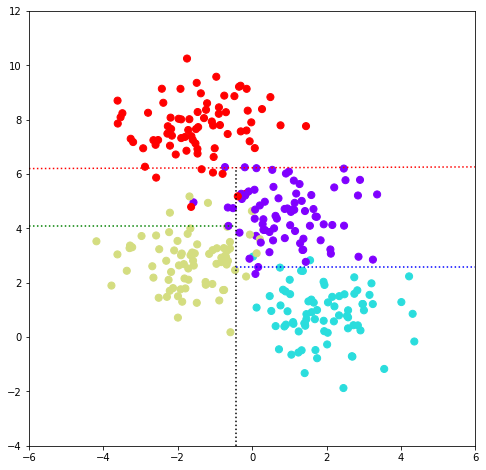

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

#lineas de clasificación de cada nivel
x_n1 = np.linspace(-6, 6, 1000)
y_n1 = np.linspace(6.2, 6.2611, 1000)
plt.plot(x_n1, y_n1, c='r',  linestyle=':');

x_n2 = np.linspace(-0.422, -0.422, 1000)
y_n2 = np.linspace(-4,  6.2611, 1000)
plt.plot(x_n2, y_n2, c='k',  linestyle=':');

x_n3a = np.linspace(-0.422, 6, 1000)
y_n3a = np.linspace(2.5666,  2.5666, 1000)
plt.plot(x_n3a, y_n3a, c='b',  linestyle=':');

x_n3b = np.linspace(-6, -0.422, 1000)
y_n3b = np.linspace(4.075,  4.075, 1000)
plt.plot(x_n3b, y_n3b, c='g',  linestyle=':');


plt.xlim((-6, 6))
plt.ylim((-4, 12))

Un método para analizar el arbol es ver que parte del arbol sigue la mayor parte de los datos. En nuestro caso hemos generado cuatro clases con 75 muestras cada una y en el grafo del arbol podemos ir viendo el número de muestras que caen en cada decisión. Vemos que solo una clase está con $X_1> 6.2$, mientras que el resto, la mayoría de los datos está por debajo. Esto nos indica que la variable $X_1$ es una variable muy significativa para la clasificación. Después vemos que la mayoría queda $X_0> -0.4$ y así sucesibamente vamos viendo como son las decisiones a cada paso.

En lugar de analizar en detalle todo el arbol, que puede ser costoso, hay algunas estadísticas que nos ayudan a conocer las propiedades del arbol.

La más utilizada es la medida de la __importancia de las variables__ de entrada. Esta estadística valora en un número entre 0 y 1 la importancia de cada variable en la clasificación final del arbol. Una importancia de valor 0, significa que esta variable no se utiliza esa variable en la clasificación y de 1, que esta variable predice de manera perfecta el objetivo de la clasificación.

Esto se mide con el parámetro del modelo ``feature_importances``:


In [ ]:
tree.feature_importances_


array([0.34106782, 0.65893218])

Y ponemos hacer una gráfica de barras para representar los valores obtenidos de la importancia de las variables de entrada.

Vemos que la variable $X_1$ es más decisiva a la hora de hacer la clasificación:

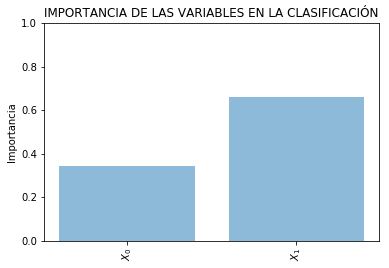

In [ ]:
features_names=['$X_0$','$X_1$']
x_pos = np.arange(len(features_names))
y_val = tree.feature_importances_
plt.ylim(0, 1)
 
plt.bar(x_pos, y_val, align='center', alpha=0.5)
plt.xticks(x_pos,features_names, rotation=90)
plt.ylabel('Importancia')
plt.title('IMPORTANCIA DE LAS VARIABLES EN LA CLASIFICACIÓN')

El arbol se contruye de manera heurística de forma que si una de las variables no tiene importancia, no significa necesariamente que es no explicativa de la clasificación sino que también puede ser que otra variable contenga ya esta información y haya sido elegida en el arbol de decisión en lugar de la anterior.

En constraste con los modelos lineales vistos anteriormente, donde los coeficientes pueden ser negativos, en este caso la importancia de las variables es siempre positiva y no indica para qué clase es significativa cada variable.


## 1.4 Evaluación del modelo

Medimos el scoring del modelo sobre el set de entrenamiento. Vemos que este scoring es perfecto. Este resultado es totalmente logicamente, porque el arbol clasifica correctamente todas las muestras del set de entrenamiento.

Aplicamos la validación cruzada y vemos la calidad de la clasificación. Vemos que no es muy buena, en realidad hemos hecho un arbol muy profundo que clasifica perfectamente el set de entrenamiento pero no generaliza bien.


In [ ]:
from sklearn.model_selection import cross_val_score
scores= cross_val_score(tree, X, y, cv=5)
print('scores -> ', scores)
print('media de la calidad del modelo ->', scores.mean())

scores ->  [0.88333333 0.88333333 0.93333333 0.9        0.9       ]
media de la calidad del modelo -> 0.9


El sobreajuste puede deberse a que el arbol tiene hojas con muy pocas muestras y es necesario hacer una partición muy específica del espacio de variables para clasificar esta minoría de muestras.

Tipicamente un arbol donde todas las hojas tienen clases puras con pocas muestras va a ser siempre muy complejo y sobreajustará los datos.

El arbol debería de recoger decisiones que clasifican el comportamiento general de los datos de entrada y no los datos más extremos o el ruido. Si funciona de esta manera clasificará mejor en términos generales con nuevas muestras de datos.

Hay dos maneras de prevenir el sobre ajuste en los árboles de decision:

- (pre-pruning) parar el nivel de profundidad del arbol antes de terminar la clasificación completa

- (post-pruning) hacer la clasificación completa y luego quitar las hojas que continen pocas muestras o poca información

en scikit-learn puede hacerse pre-pruning y por ejemplo, podemos parar el arbol de acuerdo a los siguientes criterios: fijar una profundidad maxima, fijar un numero máximo de hojas o requerir un número minimo de muestras en las hojas.
 
Si fijamos la maxima profundidad con el parámetro *max_depth* en un nivel 3, vemos si mejora la validación cruzada:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=9).fit(X, y)

scores= cross_val_score(tree, X, y, cv=5)
print('scores -> ', scores)
print('media de la calidad del modelo ->', scores.mean())

scores ->  [0.88333333 0.88333333 0.9        0.9        0.9       ]
media de la calidad del modelo -> 0.8933333333333333


Si dibujamos la curva de validación, vemos que en efecto la profundidad optima está en torno a 3 o 5 niveles:

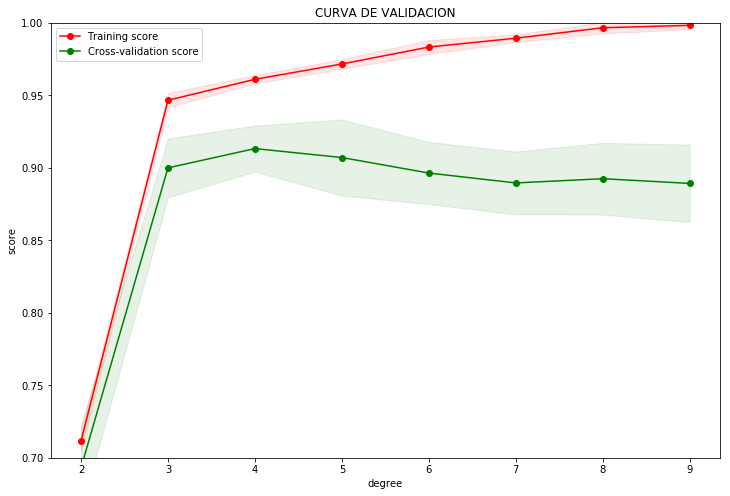

In [ ]:
from sklearn.model_selection import validation_curve

##THE DECISION TREE MODEL
#build the pipeline
def myDecissionTree(degree=2):
    return DecisionTreeClassifier(max_depth=degree)

## GENERATE VALIDATION CURVES
degree = np.arange(2, 10)
train_scores, test_scores = validation_curve(myDecissionTree(), X, y,'max_depth', degree, cv=7)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


## REPRESENTACIÓN GRÁFICA
plt.figure(figsize=(12, 8))
plt.title("CURVA DE VALIDACION")

plt.fill_between(degree, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(degree, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(degree, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(degree, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc='best')
plt.ylim(0.7, 1) #zoom entre 0.9 y 1
plt.xlabel('degree')
plt.ylabel('score');

## 1.5 Medidas de calidad de una clasificación

El análisis de errores de la clasificación nos proporciona un mecanismo de evaluación numérica para estiar la calidad de la clasificación. 

Para medir estos errores definiremos los conceptos de:

* __P__ = condicion positiva (P). El numero de casos realmente positivos en los datos
* __N__ = condicion negativa (N). El numero de casos realmente negativos en los datos
* __TP__ = Verdadero Positivo (TP). Eqv. con acierto 
* __TN__ = Verdadero Negativo (TN). Eqv. con rechazo correcto
* __FP__ = Falso Positivo (FP). Eqv. con falsa alarma, <a href="https://en.wikipedia.org/wiki/Type_I_and_type_II_errors#Type_I_error">error de Tipo I</a>
* __FN__ = Falso Negativo (FN). Eqv. a pasado por alto, <a href="https://en.wikipedia.org/wiki/Type_I_and_type_II_errors#Type_II_error">error de Tipo II</a>

Todo ello se represnta en la denominada __MATRIZ DE CONFUSION__ . Una matriz $C$ cuyos elementos $C_{i, j}$ es el numero de muestras que pertenecen a la clase $i$ y han sido predichas en la clase $j$.

Construimos un modelo con los datos iniciales y mediremos su calidad:

In [ ]:
##CONTRUIMOS NUESTRO SET DE CROSS VALIDATION
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,random_state=0)
print('Tamaño del set de entrenamiento: ',ytrain.shape[0])
print('Tamaño del set de validación: ',ytest.shape[0])

##CONSTRUIMOS EL MODELO, LO ENTRENAMOS Y PREDECIMOS SOBRE EL SET DE TEST
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=3).fit(Xtrain, ytrain)
ypred = tree.predict(Xtest)

Tamaño del set de entrenamiento:  225
Tamaño del set de validación:  75


En SKLearn puede calcularse la matriz de confusión utilizando las librerías de metricas. Calcularemos la matriz y la representamos con un mapa de calor de seaborn:

<a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html"> Ver detalle de la metrica de la matriz de confusión</a>

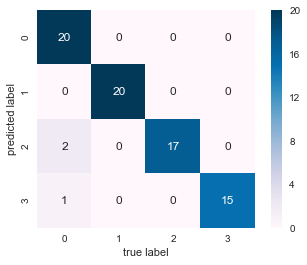

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='PuBu')
plt.xlabel('true label')
plt.ylabel('predicted label');

La calidad de la clasificación viene dada por las siguientes métricas:

__PPV__ = PRECISION o valor predictivo positivo (Positive Predictive Value). Si está proximo a 1 significa que hay pocos FP, los positivos que hemos encontrado son ciertos.
$$\begin{align}PPV =\frac{TP}{TP+FP}\end{align}$$

__TPR__ = SENSIBILIDAD o recall, tasa de acierto o tasa de verdaderos positivos (True Positive Rate). Si está proximo a 1 significa que hay pocos FN, no se nos ha escapado ningun positivo.
$$\begin{align}TPR = \frac{TP}{P} =\frac{TP}{TP+FN}\end{align}$$


__F1 score__ = es la media armónica entre la precisión y la sensibilidad
$$\begin{align}F_1= 2.\frac{PPV.TPR}{PPV+TPR} =\frac{2.TP}{2.TP+FP+FN}\end{align}$$

<a href="https://en.wikipedia.org/wiki/Confusion_matrix"> Ver detalle de todas las medidas de calidad de la clasificación y la matriz de confusión</a>


En SKLearn puede medirse estas magnitudes en un reporte de clasificación utilizando las librerías de metricas. Calcularemos la matriz y la representamos con un mapa de calor de seaborn:

<a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"> Ver detalle del report de clasificación</a>

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       1.00      0.87      0.93        23
          1       1.00      1.00      1.00        20
          2       0.89      1.00      0.94        17
          3       0.94      1.00      0.97        15

avg / total       0.96      0.96      0.96        75



Como observamos nuestro clasificador tiene un score $F_1$ bastante bueno en todas las clases. Predice los positivos bastante bien y tiene pocos Falsos Positivos y Falsos Negativos.

## 2. RANDOM FOREST

*Ramdom Forests* son un ejemplo de conjunto de estimadores, que se basa en agregar los resultados de  muchos arboles de decision similares pero generados con alguna variación aleatoria. 

Como hemos visto los *Arboles de Decision* tienen la desventaja de que tienden a sobreajustar los datos de entrenamiento. Los bosques aleatorios resuelven este problema.

La idea del bosque aleatorio es dar a cada arbol solo una parte de los datos. Creamos muchos arboles y cada arbol funcionará muy bien y sobreajustará su parte de los datos. El estimador del conjunto promedia los resultados de todos estos árboles para conseguir un resultado de clasificación más robusto y que generaliza mejor que un arbol individual sin llegar a su profundidad máxima.

Para implementar esta estrategia creamos arboles injectando aleatoriedad a nuestro arbol inicial de dos formas:
- en los datos: cada arbol utiliza un conjunto aleatorio de lo datos iniciales de entrenamiento diferente. Metodo *Boostraping*, tomamos el numero de muestras inicial $[a, b, c, d]$, quitamos unas cuantas $[a]$ y las sustituimos por otros valores de las que nos han quedado $[d, b, d, c]$. Esto es algunas muestras se repiten.

- en el algoritmo: en cada nodo de decisión restringimos el número máximo de variables sobre las que se puede decidir. Cada arbol tomará de manera aleatoria solo un subconjunto de variables y construirá diferentes decisiones de manera diferente a el resto de los arboles.

La aleatoriedad injectada hace que los nodos de decisión sean algo diferentes para cada carbol del bosque.

Si hacemos que el número máximo de variables ``max_features`` sea el total de variables quitamos la aleatoriedad del algoritmo y los arboles del bosque serán similares. Si hacemos que ``max_features`` sea $1$ forzamos cada arbol solo se pueda tomar la decision de crote en una variable elegida aleatoriamente, la aleatoriedad es máxima y los arboles del bosque muy diferentes.

Para hacer una prediccion el bosque aleatorio, hará una prediccion sobre todos los arboles. Para la clasificación, cada arbol da un resultado de probabilidad sobre una clase objetivo. El predictor del conjunto suma esas probabilides y las promedia. Al final la clase con mayor probabilidad es la elegida como resultado de la prediccion.


## 2.1 Generamos el modelo

Construimos un *Random Forest* y lo entrenamos sobre el conjunto de datos iniciales:

<a href='http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html'> Ver información sobre los parámetros que toma el ``RandomForestClassifier`` </a>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10, random_state=2)
forest.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
            verbose=0, warm_start=False)

## 2.2 Validamos el modelo

Podemos variar el número de arboles modificando el parámetro *n_estimators* y comprobar como mejora la validación del modelo:

In [ ]:
from sklearn.cross_validation import cross_val_score
scores= cross_val_score(forest, X, y, cv=5)
print('scores -> ', scores)
print('media de la calidad del modelo ->', scores.mean())

scores ->  [0.93333333 0.9        0.91666667 0.91666667 0.91666667]
media de la calidad del modelo -> 0.9166666666666666


E:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 2.3 Diseñamos el algoritmo

Para diseñar el modelo podemos evaluar su comportamiento frente a los parámetros de número de arboles ``n_estimators`` y  ``max_features``. En este caso solo tenemos dos variables por lo que no tienen mucho sentido optimizar ``max_features`` y podemos construir una curva de validación que nos diga el número optimo de arboles para bosque:

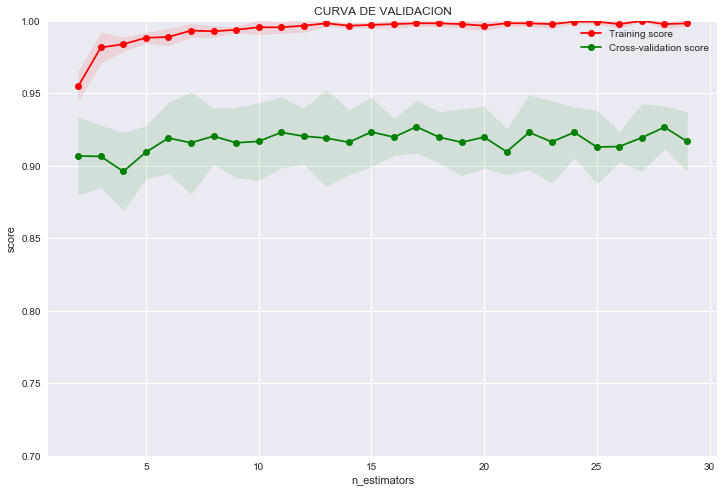

In [ ]:
from sklearn.model_selection import validation_curve

##THE RANDOM FOREST MODEL
#build the pipeline
def myRandomForest(n=2):
    return RandomForestClassifier(n_estimators=n)

## GENERATE VALIDATION CURVES
n = np.arange(2, 30)
train_scores, test_scores = validation_curve(myRandomForest(), X, y,
                                             'n_estimators', n, cv=7)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


## REPRESENTACIÓN GRÁFICA
plt.figure(figsize=(12, 8))
plt.title("CURVA DE VALIDACION")

plt.fill_between(n, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(n, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(n, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(n, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc='best')
plt.ylim(0.7, 1) #zoom entre 0.9 y 1
plt.xlabel('n_estimators')
plt.ylabel('score');

Cuantos más arboles en el bosque mas robusto es el estimador final, pero mas arboles requieren mas memoria/cpu de entrenamiento y prediccion, por lo que hay que es necesario un buen compromiso entre ambas propiedades del modelo. Vemos que un buen resultado podría ser un bosque con 10 arboles.

El estimador ``RandomForestClassifier`` genera un array de arboles que puede verse en la propiedad ``.estimators_`` del modelo. Podemos entonces calcular estadísticas sobre el bosque generado y también ver cada uno de los árboles que se ha generado.

Veamos por ejemplo el primero y analicemos el nuemro de muesrtas que ha tomado y las decisiones que ha tomado en cada nodo:

In [ ]:
#tomamos el primer arbol del bosque para verlo
tree0 = forest.estimators_[0]

Generamos la figura del arbol con las librerías *graphviz*.

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
from scipy.misc import imread

feature_names = ['X_0','X_1']
export_graphviz(tree0, out_file="figuras/mytree.dot", class_names=["CERO", "UNO","DOS","TRES"],
                feature_names=feature_names, impurity=False, filled=True)

with open("figuras/mytree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)
graph = graphviz.Source(dot_graph, format="png")
graph.render("figuras/1_forest_estimator0")
imread("figuras/1_forest_estimator0.png"); #avoid output with ';'

<!-- Para incluir una imagen en una celda de markdown se usa ![](path_img)-->
![](figuras/1_forest_estimator0.png)

Similarmente, el estimador forest también puede indicarnos la importancia de las diferentes variables en el modelo:

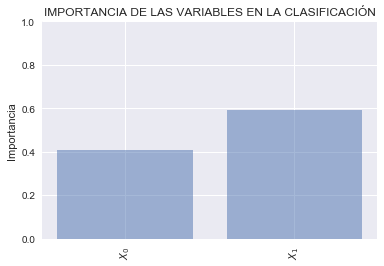

In [ ]:
features_names=['$X_0$','$X_1$']
x_pos = np.arange(len(features_names))
y_val = tree0.feature_importances_
plt.ylim(0, 1)
 
plt.bar(x_pos, y_val, align='center', alpha=0.5)
plt.xticks(x_pos,features_names, rotation=90)
plt.ylabel('Importancia')
plt.title('IMPORTANCIA DE LAS VARIABLES EN LA CLASIFICACIÓN')

# 3. Gradient Boosting Machines

Los ``Gradient Boosted Trees`` son otro ejemplo de conjunto de estimadores construido sobre árboles de decision.

En contraste con los bosques aleatorios, este algoritmo lo que hace es crear una serie de árboles, en los que cada uno corrige los defectos del anterior. No hay aleatoriedad en la construccion sino que se busca un sobreajuste muy fuerte pero con arboles muy sencillos. Esto hace que el algoritmo sea más eficiente en términos de consumo de memoria y CPU, siendo más rapido en los entrenamientos y en las predicciones.

La idea es hacer estimadores muy simples, arboles de poca profundidad que funcionan bien, pero solo sobre una pequeña parte de los datos. Cada arbol predice muy bien una parte de los datos y así añadiendo más arboles, obtenemos un modelo más robusto.


## 3.1 Generamos el modelo

Construimos un *GradientBoostingClassifier* y lo entrenamos sobre el conjunto de datos iniciales:

<a href='http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html'> Ver información sobre los parámetros que toma el ``GradientBoostingClassifier`` </a>


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

Vemos los parametros con los que se ejecuta el algoritmo. Podemos probar el modelo con diferentes parametros de profundidad máxima ``max_depth`` y velocidad de aprendizaje  ``learning_rate``.

## 3.2 Validamos el modelo

Hacemos una medida de validación y vemos que mejora el scoring obtenido por los *Random Forests*

In [ ]:
from sklearn.cross_validation import cross_val_score
scores= cross_val_score(gbrt, X, y, cv=5)
print('scores -> ', scores)
print('media de la calidad del modelo ->', scores.mean())

scores ->  [0.9        0.91666667 0.93333333 0.93333333 0.95      ]
media de la calidad del modelo -> 0.9266666666666667


## 3.3 Diseñamos el modelo

Para diseñar este modelo a parte de añadir más árboles con el parámetro `` n_estimators`` para hacerlo más complejo, podemos fijar la velocidad de aprendizaje del algoritmo. Esto se hace con el parámetro ``learning_rate`` que controla como de fuertes son las correcciones que hace cada arbol sobre el anterior.

- Una velocidad alta significa que se hacen correcciones fuertes, permitiendo que los arboles individuales sean más profundos y complejos.

- Una velocidad más baja hace que las correcciones sean más ligeras y el modelo más simple.

Diseñamos las curvas de validación variando el numero de arboles:

E:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


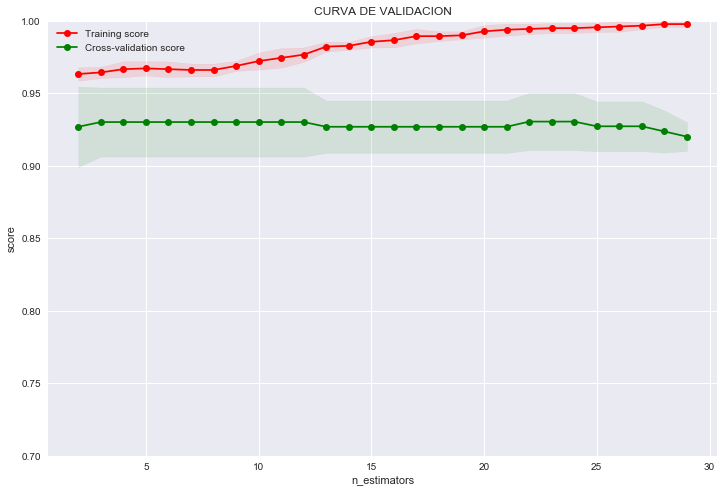

In [ ]:
from sklearn.learning_curve import validation_curve

##THE GRADIENT BOOSTER CLASSIFIER MODEL
#build the pipeline
def myGradientBooster(n=2):
    return  GradientBoostingClassifier(n_estimators=n)

## GENERATE VALIDATION CURVES
n = np.arange(2, 30)
train_scores, test_scores = validation_curve(myGradientBooster(), X, y,'n_estimators', n, cv=7)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


## REPRESENTACIÓN GRÁFICA
plt.figure(figsize=(12, 8))
plt.title("CURVA DE VALIDACION")

plt.fill_between(n, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(n, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(n, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(n, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc='best')
plt.ylim(0.7, 1) #zoom entre 0.9 y 1
plt.xlabel('n_estimators')
plt.ylabel('score');

Parece que lo optimo está en torno a 20 ó 25 arboles. 

Trazamos las curvas de validación fijando el número de estimadores a 25 y variando la velocidad de aprendizaje: 

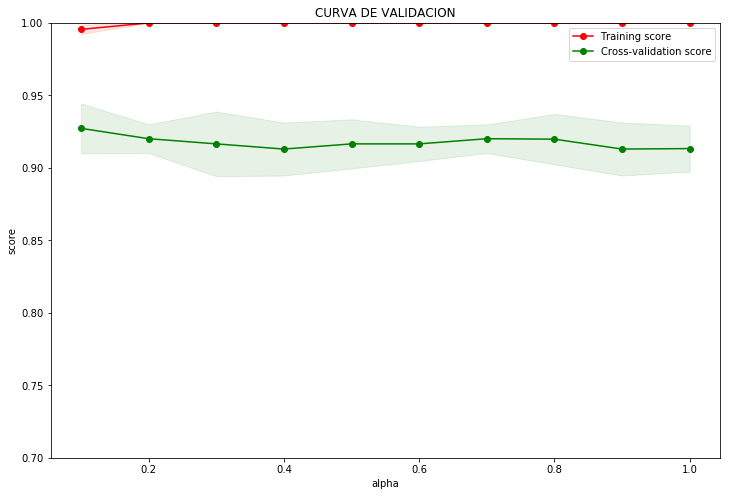

In [ ]:
##THE GRADIENT BOOSTER CLASSIFIER MODEL
#build the pipeline
def myGradientBooster(alpha=0.1):
    return  GradientBoostingClassifier(n_estimators= 25,learning_rate=alpha)

## GENERATE VALIDATION CURVES
alpha = np.arange(1.0,11.0)/10.0
train_scores, test_scores = validation_curve(myGradientBooster(), X, y,'learning_rate', alpha, cv=7)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


## REPRESENTACIÓN GRÁFICA
plt.figure(figsize=(12, 8))
plt.title("CURVA DE VALIDACION")

plt.fill_between(alpha, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(alpha, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(alpha, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(alpha, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc='best')
plt.ylim(0.7, 1) #zoom entre 0.9 y 1
plt.xlabel('alpha')
plt.ylabel('score');

Podemos ver que el valor máximo para los datos de test es para la velocidad de aprendizaje más baja $learning_{rate}=0.1$.

Imprimimos los scores obtenidos con esa $\alpha$

In [ ]:
print('Scores alpha 0.1: ', test_scores[0])
print('La media de los scores alpha 0.1: ', test_scores[0].mean())

Scores alpha 0.1:  [0.93181818 0.88636364 0.90909091 0.90909091 0.97727273 0.925
 0.95      ]
La media de los scores alpha 0.1:  0.9269480519480519


# Ejercicio 1: Prediccion de cancer de mama

Hacer un modelo de clasificación con los datos de cancer de mama de SKLearn y analizar el arbol generado:

<a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html">Detalle sobre el dataset de cancer de mama</a>

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
print('Variables: ',cancer.feature_names)
print('Clases: ',cancer.target_names)

#EL MODELO: UN ARBOL CON TOTAL PROFUNDIDAD
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

print('Accuracy on the training subset: {:.3f}'.format(tree.score(X_train, y_train)))
print('Accuracy on the test subset: {:.3f}'.format(tree.score(X_test, y_test)))

Variables:  ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Clases:  ['malignant' 'benign']
Accuracy on the training subset: 1.000
Accuracy on the test subset: 0.937


In [ ]:
tree = DecisionTreeClassifier(max_depth=4,random_state=0)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print('Accuracy on the training subset: {:.3f}'.format(tree.score(X_train, y_train)))
print('Accuracy on the test subset: {:.3f}'.format(tree.score(X_test, y_test)))

Accuracy on the training subset: 0.988
Accuracy on the test subset: 0.951


Analizamos el arbol generado.

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file='figuras/cancertree.dot',
                class_names=cancer.target_names,
                feature_names=cancer.feature_names,
               impurity=False, filled=True)

with open("figuras/cancertree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)
graph = graphviz.Source(dot_graph, format="png")
graph.render("figuras/2_cancertree")
imread("figuras/2_cancertree.png"); #avoid output with ';'

<!-- Para incluir una imagen en una celda de markdown se usa ![](path_img)-->
![](figuras/2_cancertree.png)

Representamos la importancia de las variables:

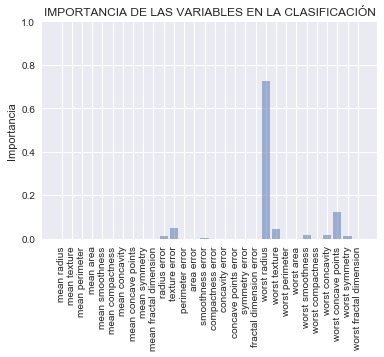

In [ ]:
features_names= cancer.feature_names
x_pos = np.arange(len(features_names))
y_val = tree.feature_importances_
plt.ylim(0, 1)
 
plt.bar(x_pos, y_val, align='center', alpha=0.5)
plt.xticks(x_pos,features_names, rotation=90)
plt.ylabel('Importancia')
plt.title('IMPORTANCIA DE LAS VARIABLES EN LA CLASIFICACIÓN')

Medimos la matriz de confusión y la representamos en un mapa de calor:

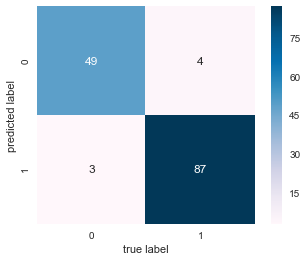

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='PuBu')
plt.xlabel('true label')
plt.ylabel('predicted label');

Calculamos el reporte de la calidad de la clasificación:

In [ ]:
from sklearn import metrics

y_pred = tree.predict(X_test)
print('Tamaño del set de entrenamiento: ',y_train.shape[0])
print('Tamaño del set de validación: ',y_test.shape[0])

print(metrics.classification_report(y_pred, y_test))

Tamaño del set de entrenamiento:  426
Tamaño del set de validación:  143
             precision    recall  f1-score   support

          0       0.92      0.94      0.93        52
          1       0.97      0.96      0.96        91

avg / total       0.95      0.95      0.95       143



Como observamos nuestro clasificador tiene un score $F_1$ bastante bueno en todas las clases. Predice los positivos bastante bien y tiene pocos Falsos Positivos y Falsos Negativos.

# Ejercicio 2: Clasificando imágenes con los clasificadores Random Forest y Gradient Boosted

Tomamos el set de datos de <a href='http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits'>imágenes de digitos</a> que viene en Scikit-Learn. 


Utilizamos los conjuntos de arboles estudiados: Random Forests y Gradient Boosted Classifiers.

Importamos el set de datos:

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [ ]:
digits['target_names']

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Para ver como son estas imágenes visualizamos las primeros 64 muestras en los datos:

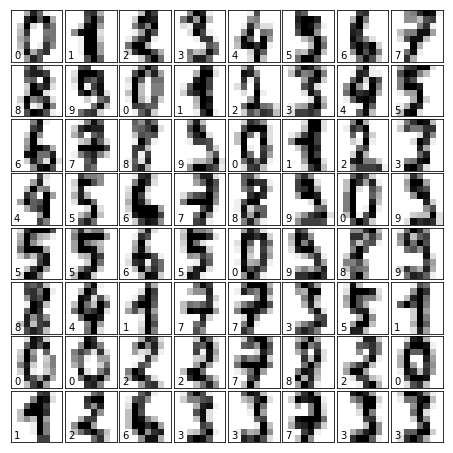

In [ ]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Tomamos los datos de entrado, dividimos el conjunto de datos en los de entrenamiento y test. Utilizamos los datos de entrenamiento para hacer el clasificador:

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=100)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Y medimos el scoring de clasificación que hemos alcanzado:

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99        38
          1       1.00      0.96      0.98        45
          2       0.95      1.00      0.98        42
          3       0.98      0.98      0.98        45
          4       0.97      1.00      0.99        37
          5       0.98      0.96      0.97        49
          6       1.00      1.00      1.00        52
          7       1.00      0.96      0.98        50
          8       0.94      0.98      0.96        46
          9       0.96      0.98      0.97        46

avg / total       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix:

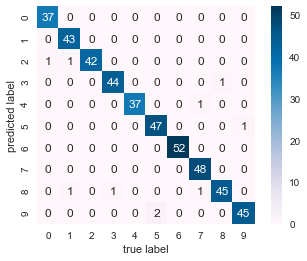

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='PuBu')
plt.xlabel('true label')
plt.ylabel('predicted label');

Probamos con Gradient Boosted y vemos si da resultados similares:

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0)

gbrt = GradientBoostingClassifier(n_estimators=100)
gbrt.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99        38
          1       1.00      0.96      0.98        45
          2       0.95      1.00      0.98        42
          3       0.98      0.98      0.98        45
          4       0.97      1.00      0.99        37
          5       0.98      0.96      0.97        49
          6       1.00      1.00      1.00        52
          7       1.00      0.96      0.98        50
          8       0.94      0.98      0.96        46
          9       0.96      0.98      0.97        46

avg / total       0.98      0.98      0.98       450



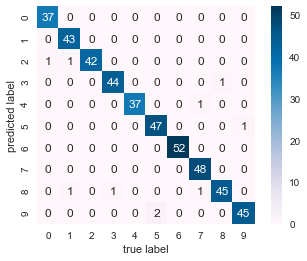

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='PuBu')
plt.xlabel('true label')
plt.ylabel('predicted label');